# IMPORTS

Por incompatibilidades entre librerias nos vemos obligados a hacer este workaround para que solucionar los problemas de dependencias.

In [2]:
import  scipy.signal.signaltools
import numpy as np

def _centered(arr, newsize):
    # Return the center newsize portion of the array.
    newsize = np.asarray(newsize)
    currsize = np.array(arr.shape)
    startind = (currsize - newsize) // 2
    endind = startind + newsize
    myslice = [slice(startind[k], endind[k]) for k in range(len(endind))]
    return arr[tuple(myslice)]

scipy.signal.signaltools._centered = _centered
import pandas as pd
import matplotlib.pyplot as plt
import os
import pickle

from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters
import pytorch_forecasting
from pytorch_forecasting import TemporalFusionTransformer, TimeSeriesDataSet
from lightning.pytorch.callbacks import EarlyStopping, LearningRateMonitor
import lightning.pytorch as pl
from lightning.pytorch.callbacks import EarlyStopping, LearningRateMonitor
from lightning.pytorch.loggers import TensorBoardLogger
import torch
from pytorch_forecasting.metrics import MAE, SMAPE, PoissonLoss, QuantileLoss
from lightning.pytorch.tuner import Tuner
from  scipy.signal.signaltools import _centered
from tft_helper import get_best_lr, tft_trainer, tft_predict, run_hyperparameter_optimization, save_exp_results


In [12]:
df = pd.read_excel(exp_path)
df['loss'] = df['loss'].map(lambda x: f'{x:.{3}f}')
df['gradient_clip_val'] = df['gradient_clip_val'].map(lambda x: f'{x:.{2}f}')
df['dropout'] = df['dropout'].map(lambda x: f'{x:.{2}f}')
df['learning_rate'] = df['learning_rate'].map(lambda x: f'{x:.{3}f}')


In [14]:
df.to_excel(exp_path, index=False)


# PARAMS

In [5]:
model_days = 365 #113
# validation_days = 14
# test_days = 15
n_prev_hours = 24*15
group = 'month'
epochs = 20
exp_path = 'TFT_experiments.xlsx'


lr_finder = False
grid_search = False

# configure network and trainer
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=10, verbose=False, mode="min")
lr_logger = LearningRateMonitor()  # log the learning rate
# logger = TensorBoardLogger("lightning_logs")  # logging results to a tensorboard


#TFT params
# tft_params =  {'gradient_clip_val': 0.05808054277495504, 'hidden_size': 32, 'dropout': 0.2997107370422699, 'hidden_continuous_size': 19, 'attention_head_size': 2, 'learning_rate': 0.017853144294677083}
# tft_params =  {'gradient_clip_val': 0.01, 'hidden_size': 36, 'dropout': 0.3, 'hidden_continuous_size': 22, 'attention_head_size': 4, 'learning_rate': 0.001}
# tft_params = {'gradient_clip_val': 0.46964879113018865, 'hidden_size': 8, 'dropout': 0.10391553098833228, 'hidden_continuous_size': 8, 'attention_head_size': 4, 'learning_rate': 0.2855372166883186}
tft_params =  {'gradient_clip_val': 0.03, 'hidden_size': 24, 'dropout': 0.25, 'hidden_continuous_size': 24, 'attention_head_size': 4, 'learning_rate': 0.01}


hyperparams_grid = {
    "gradient_clip_val_range": (0.01, 1.0),
    "hidden_size_range": (8, 64),
    "hidden_continuous_size_range": (8, 64),
    "attention_head_size_range": (1, 4),
    "learning_rate_range": (0.001, 0.3),
    "dropout_range": (0.1, 0.3),
    "trainer_kwargs": dict(limit_train_batches=60),
    "reduce_on_plateau_patience": 4,
    "use_learning_rate_finder": False
}




# LOAD DATA

In [3]:
# Cargar los datos
file_path =  './datasets/dataset_input_v1.xlsx'

df = pd.read_excel(file_path)

df = df.rename(columns={'EUA': 'co2'})
df['fechaHora'] = pd.to_datetime(df['fechaHora'])

df = df.dropna(subset=['precio_spot'])


In [4]:
df

,fechaHora,precio_spot,demanda,co2,precio_gas,prod_eolica,prod_solar,demanda_residual,rampa
0,2019-01-01 01:00:00,66.88,22781.000000,24.18,24.45,3782.166667,29.166667,19101.300,824.100
1,2019-01-01 02:00:00,66.00,21448.500000,24.18,24.45,3740.333333,23.500000,17924.100,1177.200
2,2019-01-01 03:00:00,63.64,20262.166667,24.18,24.45,3711.500000,14.000000,16725.000,1199.100
3,2019-01-01 04:00:00,58.85,19463.500000,24.18,24.45,3530.000000,14.000000,15826.800,898.200
4,2019-01-01 05:00:00,55.47,19164.000000,24.18,24.45,3390.166667,14.000000,15769.300,57.500
...,...,...,...,...,...,...,...,...,...
46531,2024-04-22 19:00:00,0.45,27209.083000,64.54,30.43,11333.333000,9408.916667,10095.400,-5391.325
46532,2024-04-22 20:00:00,6.00,29248.333000,64.54,30.43,13670.417000,3038.250000,16069.450,-5974.050
46533,2024-04-22 21:00:00,12.81,30731.833000,64.54,30.43,13265.333000,1025.916667,17111.625,-1042.175
46534,2024-04-22 22:00:00,7.62,28432.417000,64.54,30.43,12733.917000,932.833333,14830.575,2281.050


<!-- ## DF FINL -->

In [5]:
now = pd.Timestamp.now()
last_day = df['fechaHora'].iloc[-1]
# Calcula la fecha hace dos meses utilizando timedelta
fecha_start = (last_day - pd.Timedelta(days=model_days)).replace(hour=0, minute=0, second=0)

# Filtra las filas 
df_last = df[df['fechaHora'] >= fecha_start]
df_last.loc[:,'precio_spot'] = np.where(df_last['precio_spot'] < 0, 0, df_last['precio_spot'])



C:\Users\nvegamun\AppData\Local\Temp\ipykernel_19008\866086546.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_last.loc[:,'precio_spot'] = np.where(df_last['precio_spot'] < 0, 0, df_last['precio_spot'])


In [6]:
df_last

,fechaHora,precio_spot,demanda,co2,precio_gas,prod_eolica,prod_solar,demanda_residual,rampa
37751,2023-04-23 00:00:00,108.00,20607.000,88.76,34.59,8589.917,346.333333,12367.325,2025.075
37752,2023-04-23 01:00:00,97.52,19405.250,88.76,34.59,8951.833,238.666667,10871.725,1495.600
37753,2023-04-23 02:00:00,95.02,18445.833,88.76,34.59,9192.583,236.666667,9538.450,1333.275
37754,2023-04-23 03:00:00,89.44,17952.000,88.76,34.59,9227.917,217.916667,8763.675,774.775
37755,2023-04-23 04:00:00,86.67,17793.000,88.76,34.59,8885.250,211.416667,8246.650,517.025
...,...,...,...,...,...,...,...,...,...
46531,2024-04-22 19:00:00,0.45,27209.083,64.54,30.43,11333.333,9408.916667,10095.400,-5391.325
46532,2024-04-22 20:00:00,6.00,29248.333,64.54,30.43,13670.417,3038.250000,16069.450,-5974.050
46533,2024-04-22 21:00:00,12.81,30731.833,64.54,30.43,13265.333,1025.916667,17111.625,-1042.175
46534,2024-04-22 22:00:00,7.62,28432.417,64.54,30.43,12733.917,932.833333,14830.575,2281.050


## DATA SPLIT

In [7]:

data = df_last.copy()
data = data.reset_index(drop=True)
data = data.drop_duplicates('fechaHora', keep='last')



In [8]:
# data = data[data['fechaHora'] < '2024-04-21 00:00:00']


In [9]:


data['month'] = data['fechaHora'].dt.to_period('M').astype(str).astype('category').cat.codes
data['week'] = data['fechaHora'].dt.strftime('%Y-%U').astype(str).astype('category').cat.codes
# data['day'] = data['fechaHora'].dt.day.astype('category').cat.codes

data['day'] = (data['fechaHora'] - data['fechaHora'].min()).dt.days
data['hour'] = data['fechaHora'].dt.hour


data['time_idx'] = data.groupby(group).cumcount() 



In [10]:
data


,fechaHora,precio_spot,demanda,co2,precio_gas,prod_eolica,prod_solar,demanda_residual,rampa,month,week,day,hour,time_idx
0,2023-04-23 00:00:00,108.00,20607.000,88.76,34.59,8589.917,346.333333,12367.325,2025.075,0,0,0,0,0
1,2023-04-23 01:00:00,97.52,19405.250,88.76,34.59,8951.833,238.666667,10871.725,1495.600,0,0,0,1,1
2,2023-04-23 02:00:00,95.02,18445.833,88.76,34.59,9192.583,236.666667,9538.450,1333.275,0,0,0,2,2
3,2023-04-23 03:00:00,89.44,17952.000,88.76,34.59,9227.917,217.916667,8763.675,774.775,0,0,0,3,3
4,2023-04-23 04:00:00,86.67,17793.000,88.76,34.59,8885.250,211.416667,8246.650,517.025,0,0,0,4,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8780,2024-04-22 19:00:00,0.45,27209.083,64.54,30.43,11333.333,9408.916667,10095.400,-5391.325,12,53,365,19,523
8781,2024-04-22 20:00:00,6.00,29248.333,64.54,30.43,13670.417,3038.250000,16069.450,-5974.050,12,53,365,20,524
8782,2024-04-22 21:00:00,12.81,30731.833,64.54,30.43,13265.333,1025.916667,17111.625,-1042.175,12,53,365,21,525
8783,2024-04-22 22:00:00,7.62,28432.417,64.54,30.43,12733.917,932.833333,14830.575,2281.050,12,53,365,22,526


## TimeSeriesDataset

In [11]:

features = [col for col in data.columns if col != 'precio_spot' ]  # Columnas de características and col != 'fechaHora'

max_prediction_length = 24
max_encoder_length = n_prev_hours #48
# training_cutoff = data["fechaHora"].max() - pd.Timedelta(hours=max_encoder_length)
training_cutoff = data["time_idx"].max() - max_prediction_length


train = TimeSeriesDataSet(
    data[lambda x: x.time_idx <= training_cutoff],
    time_idx="time_idx",
    target="precio_spot",
    group_ids=[group],
   min_encoder_length=24,  # keep encoder length long (as it is in the validation set)
    max_encoder_length=max_encoder_length,
    #min_prediction_length=24,
    max_prediction_length=max_prediction_length,
    static_categoricals=[],
    static_reals=[],
    time_varying_known_categoricals=[], # group of categorical variables can be treated as one variable
    time_varying_known_reals=features,
    time_varying_unknown_categoricals=[],
    time_varying_unknown_reals=['precio_spot'],
    lags={'precio_spot': [24,48,72]},
    target_normalizer=GroupNormalizer('robust',
        groups=[group],
        transformation="softplus"
    ),
  
   # use softplus and normalize by group
    add_relative_time_idx=True,
    add_target_scales=True,
    # allow_missing_timesteps=True,
    # add_encoder_length=True,
    categorical_encoders={
        'month':pytorch_forecasting.data.encoders.NaNLabelEncoder(add_nan=True),
        'week':pytorch_forecasting.data.encoders.NaNLabelEncoder(add_nan=True),
        'day':pytorch_forecasting.data.encoders.NaNLabelEncoder(add_nan=True),
        
    },
)

validation = TimeSeriesDataSet.from_dataset(train, data, predict=True, stop_randomization=True)
# test = TimeSeriesDataSet.from_dataset(training, test_data, predict=True, stop_randomization=True)

# create dataloaders for model
batch_size = 64  # set this between 32 to 128
train_dataloader = train.to_dataloader(train=True, batch_size=batch_size, num_workers=11, persistent_workers=True)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size, num_workers=11, persistent_workers=True)
# test_dataloader = test.to_dataloader(train=False, batch_size=batch_size, num_workers=11, persistent_workers=True)


c:\Users\nvegamun\AppData\Local\anaconda3\envs\tfg\lib\site-packages\pytorch_forecasting\data\encoders.py:318: UserWarning: Found 1 unknown classes which were set to NaN
  warnings.warn(
c:\Users\nvegamun\AppData\Local\anaconda3\envs\tfg\lib\site-packages\pytorch_forecasting\data\encoders.py:318: UserWarning: Found 1 unknown classes which were set to NaN
  warnings.warn(
c:\Users\nvegamun\AppData\Local\anaconda3\envs\tfg\lib\site-packages\torch\utils\data\dataloader.py:560: UserWarning: This DataLoader will create 11 worker processes in total. Our suggested max number of worker in current system is 8 (`cpuset` is not taken into account), which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [12]:
validation

TimeSeriesDataSet[length=13](
	time_idx='time_idx',
	target='precio_spot',
	group_ids=['month'],
	weight=None,
	max_encoder_length=360,
	min_encoder_length=24,
	min_prediction_idx=0,
	min_prediction_length=24,
	max_prediction_length=24,
	static_categoricals=[],
	static_reals=['encoder_length', 'precio_spot_center', 'precio_spot_scale'],
	time_varying_known_categoricals=[],
	time_varying_known_reals=['fechaHora', 'demanda', 'co2', 'precio_gas', 'prod_eolica', 'prod_solar', 'demanda_residual', 'rampa', 'month', 'week', 'day', 'hour', 'time_idx', 'relative_time_idx', 'precio_spot_lagged_by_24', 'precio_spot_lagged_by_48', 'precio_spot_lagged_by_72'],
	time_varying_unknown_categoricals=[],
	time_varying_unknown_reals=['precio_spot'],
	variable_groups={},
	constant_fill_strategy={},
	allow_missing_timesteps=False,
	lags={'precio_spot': [24, 48, 72]},
	add_relative_time_idx=True,
	add_target_scales=True,
	add_encoder_length=True,
	target_normalizer=GroupNormalizer(
	method='robust',
	groups=


# LEARNIG RATE FINDER

En primer lugar realizamos un estudio para hallar de forma aproximada el valor optimo de tasa de aprendizaje.  No es recomendable al 100% usar el valor sugerido directamente pues a veces no encuentra el mejor, sin embargo si que da un muy buen punto de partida por donde empezar a probar. Para ello usamos un modelo TFT cualquiera basico.

In [13]:
if lr_finder:
    res = get_best_lr(train, train_dataloader, val_dataloader, **tft_params)


# MODELLING

In [14]:
# use_suggested_lr = input('Use suggested lr??
# if use_suggested_lr:
#     tft_params['learning_rate'] = res
# else:

    

## TRAIN MODEL

In [15]:
if not grid_search:
    tft_params['learning_rate'] = 0.01
    tft, val_loss = tft_trainer(train, train_dataloader, val_dataloader, max_epochs=epochs, model_path='model_month_365_360', **tft_params)
    save_exp_results(exp_path, tft_params, model_days, n_prev_hours, group, val_loss, epochs)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
c:\Users\nvegamun\AppData\Local\anaconda3\envs\tfg\lib\site-packages\lightning\pytorch\utilities\parsing.py:199: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
c:\Users\nvegamun\AppData\Local\anaconda3\envs\tfg\lib\site-packages\lightning\pytorch\utilities\parsing.py:199: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.

   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\nvegamun\AppData\Local\anaconda3\envs\tfg\lib\site-packages\torch\utils\data\dataloader.py:560: UserWarning: This DataLoader will create 11 worker processes in total. Our suggested max number of worker in current system is 8 (`cpuset` is not taken into account), which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


c:\Users\nvegamun\AppData\Local\anaconda3\envs\tfg\lib\site-packages\torch\utils\data\dataloader.py:560: UserWarning: This DataLoader will create 11 worker processes in total. Our suggested max number of worker in current system is 8 (`cpuset` is not taken into account), which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch 0: 100%|██████████| 64/64 [02:52<00:00,  0.37it/s, v_num=9, train_loss_step=18.50]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 64/64 [02:40<00:00,  0.40it/s, v_num=9, train_loss_step=10.70, val_loss=12.50, train_loss_epoch=21.90]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 64/64 [02:34<00:00,  0.41it/s, v_num=9, train_loss_step=6.440, val_loss=6.280, train_loss_epoch=11.50]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 64/64 [02:31<00:00,  0.42it/s, v_num=9, train_loss_step=5.270, val_loss=4.480, train_loss_epoch=7.250]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 64/64 [02:35<00:00,  0.41it/s, v_num=9, train_loss_step=4.220, val_loss=4.050, train_loss_epoch=5.450]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██████████| 64/64 [02:35<00:00,  0.41it/s, v_num=9, train_loss_step=4.580, val_loss=4.020, train_loss_epoch=4.750]
Validation: |          | 0/? [00:00<

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 64/64 [02:43<00:00,  0.39it/s, v_num=9, train_loss_step=2.360, val_loss=3.350, train_loss_epoch=2.870]
Number of parameters in network: 142.3k


c:\Users\nvegamun\Documents\SPOT-Price-Forecast-NN\src\tft_helper.py:229: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tft_exps = tft_exps.append(new_exp, ignore_index=True)


### EVAL MODEL

In [1]:
if not grid_search:
    preds = tft_predict(tft, val_dataloader)


NameError: name 'grid_search' is not defined

In [17]:
import matplotlib.pyplot as plt

def tft_predict2(tft, data, n_preds=None, **kwargs):
    # Realiza las predicciones
    predictions = tft.predict(data, mode="raw", return_x=True)

    # Define el número de predicciones a visualizar/guardar
    num_predictions = n_preds if n_preds is not None else predictions.output[0].shape[0]

    for idx in range(num_predictions):
        # Genera la predicción y el gráfico
        fig, ax = plt.subplots()
        tft.plot_prediction(predictions.x, predictions.output, idx=idx, add_loss_to_title=True, ax=ax)

        # Construye el nombre del archivo usando kwargs
        filename = f"../predictions/model_{kwargs.get('group', 'none')}_{kwargs.get('model_days', 'nonw')}_{kwargs.get('n_prev_hours', 'none')}/prediction_{idx}.png"
        
        # Crea el directorio si no existe
        os.makedirs(os.path.dirname(filename), exist_ok=True)

        # Guarda el gráfico en un archivo PNG
        plt.savefig(filename)
        plt.close(fig)  # Cierra la figura para liberar memoria

    return predictions


In [18]:
model_name = {'model_days': model_days, 'group': group, 'n_prev_hours': n_prev_hours}

preds = tft_predict2(tft, data, n_preds=None, **model_name)

c:\Users\nvegamun\AppData\Local\anaconda3\envs\tfg\lib\site-packages\pytorch_forecasting\data\encoders.py:318: UserWarning: Found 1 unknown classes which were set to NaN
  warnings.warn(
c:\Users\nvegamun\AppData\Local\anaconda3\envs\tfg\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


## GRID SEARCH

In [19]:
if grid_search:
    study, best_tft = run_hyperparameter_optimization(train, train_dataloader, val_dataloader, n_trials=50, max_epochs=30, **hyperparams_grid)
    print(study.best_trial.params)

Podemos cortar la ejecucion y reanudarla posteriormente si habilitamos las siguientes lineas.

### EVAL BEST FOUND MODEL

In [20]:
if grid_search:
    tft_predict(best_tft, val_dataloader, n_preds=10)


# NEW PREDS

In [22]:
real = predictions.x['encoder_target'][-1][-24:]
preds=[]
for i in predictions.output.prediction[-1]:
    preds.append(float(i[3]))


NameError: name 'predictions' is not defined

Mean Squared Error (MSE): 3.1339245833752596
Mean Absolute Error (MAE): 1.178876881442675


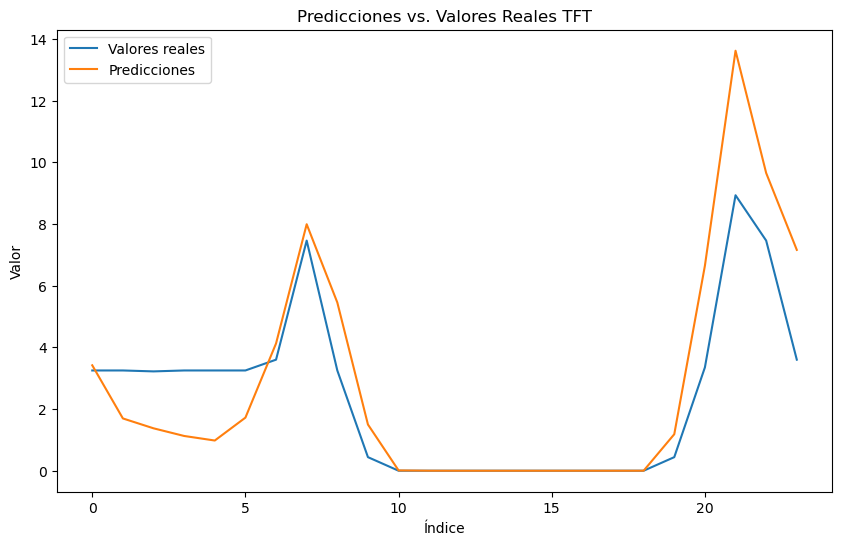

In [ ]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error, r2_score
mse = mean_squared_error(real, preds)
print('Mean Squared Error (MSE):', mse)

# Calcular el Error Absoluto Medio (MAE)
mae = mean_absolute_error(real, preds)
print('Mean Absolute Error (MAE):', mae)



plt.figure(figsize=(10, 6))
plt.plot(real.flatten(), label='Valores reales')
plt.plot(preds, label='Predicciones')
plt.title('Predicciones vs. Valores Reales TFT')
plt.xlabel('Índice')
plt.ylabel('Valor')
plt.legend()
plt.show()

# INTERPRETABILITY

c:\Users\nvegamun\AppData\Local\anaconda3\envs\tfg\lib\site-packages\pytorch_forecasting\data\encoders.py:318: UserWarning: Found 1 unknown classes which were set to NaN
  warnings.warn(
c:\Users\nvegamun\AppData\Local\anaconda3\envs\tfg\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


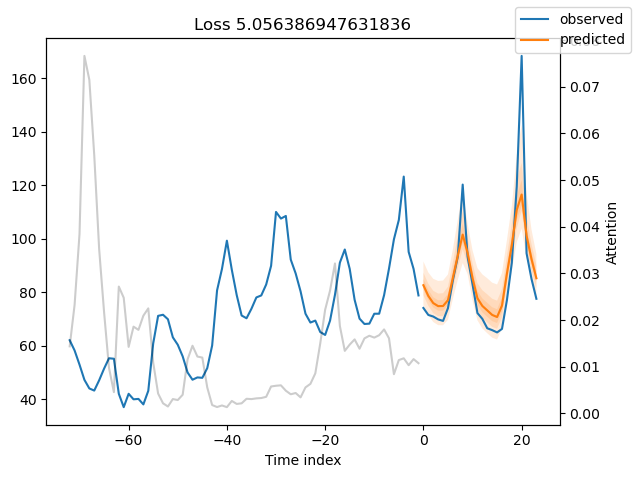

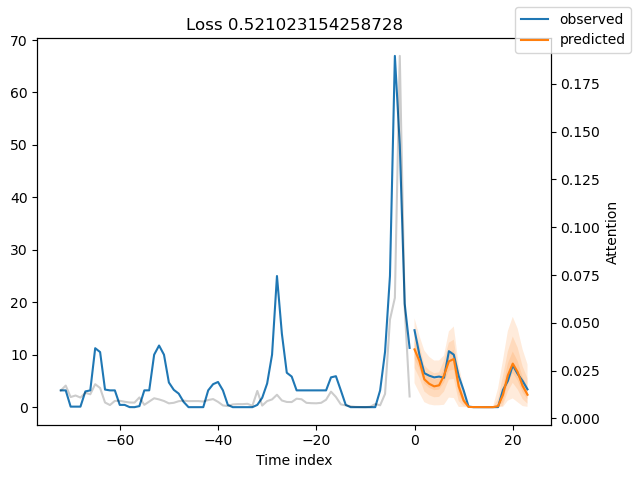

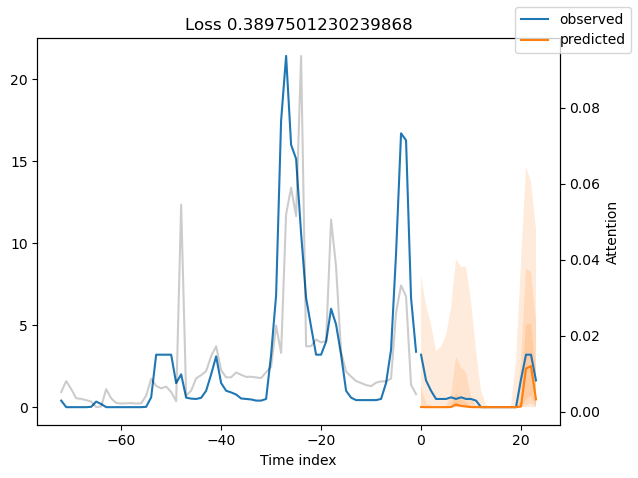

In [ ]:
predictions = tft.predict(data, mode="raw", return_x=True)
    
for idx in range(3):  # plot n_preds or  all
    tft.plot_prediction(predictions.x, predictions.output, idx=idx, add_loss_to_title=True)

In [ ]:
tft_exps = pd.read_excel(exp_path)


In [ ]:
tft_exps.sort_values(by='loss', ascending=True, inplace=True)
tft_exps =tft_exps.reset_index(drop=True)


In [ ]:
tft_exps

,model_name,loss,epochs,gradient_clip_val,hidden_size,dropout,hidden_continuous_size,attention_head_size,learning_rate
0,model_month_113_72,1.618299,30,0.010000,36,0.300000,22,4,0.010000
1,model_month_133_72,2.063174,25,0.010000,36,0.300000,22,4,0.001000
2,model_month_365_360,3.133454,20,0.030000,24,0.250000,24,4,0.005000
3,model_month_365_168,3.640000,30,0.311824,13,0.294214,8,1,0.002284
4,model_month_365_72,3.702679,25,0.010000,36,0.300000,22,4,0.001000
5,model_month_365_168,3.740182,25,0.010000,36,0.300000,22,4,0.001000
6,model_month_200_72,3.747612,40,0.030000,24,0.250000,24,2,0.010000
7,model_month_365_360,3.845517,40,0.030000,24,0.250000,24,2,0.010000
8,model_month_365_168,4.071788,20,0.058081,32,0.299711,19,2,0.150000
9,model_month_365_72,4.297079,30,0.030000,24,0.250000,24,4,0.050000


c:\Users\nvegamun\AppData\Local\anaconda3\envs\tfg\lib\site-packages\numpy\lib\stride_tricks.py:537: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  args = [np.array(_m, copy=False, subok=subok) for _m in args]
c:\Users\nvegamun\AppData\Local\anaconda3\envs\tfg\lib\site-packages\numpy\lib\stride_tricks.py:537: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  args = [np.a

RuntimeError: Boolean value of Tensor with more than one value is ambiguous

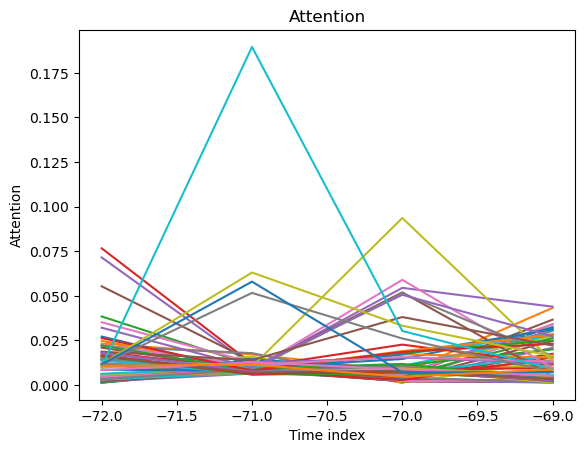

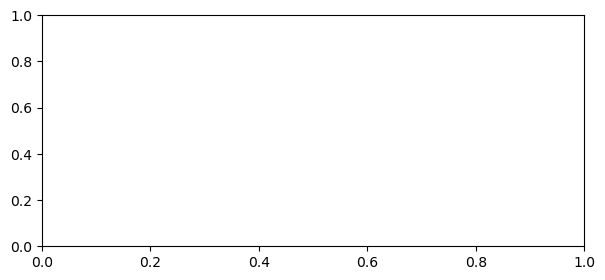

In [ ]:
interpretation = tft.interpret_output(predictions.output) #, reduction="sum"
tft.plot_interpretation(interpretation)
